In [ ]:
!nvidia-smi

Thu Apr 29 19:13:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!cat /proc/uptime | awk '{print $1 /60 /60 /24 "days (" $1 "sec)"}'

0.00190741days (164.80sec)


In [ ]:
!git clone https://github.com/yours-schnee/custom_ImageNet.git

Cloning into 'custom_ImageNet'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 61 (delta 21), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (61/61), done.


In [ ]:
!pip install -e ./custom_ImageNet

ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /content/custom_ImageNet


In [ ]:
import sys
sys.path.append('/content/custom_ImageNet')

In [ ]:
import custom_ImageNet
from utils.ImageNetDataset import make_path_list
from utils.ImageNetDataset import str_convert
from utils.ImageNetDataset import ImageNetDataset

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn import init
from torch.optim import lr_scheduler
from torch import optim

In [ ]:
import glob
import os
import time
import shutil
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.autonotebook import tqdm

from torchvision import transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.metrics import classification_report
import statistics
import itertools
np.set_printoptions(threshold=np.inf)
#from PIL import Image  
import PIL
import PIL.Image
from PIL import ImageFile

#import copy
from copy import deepcopy
from torchsummary import summary
import torch.utils.data as data

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "drive/My Drive/ImageNet/cortical_20random_ImagenetTrain.zip" /content/
!cp "drive/My Drive/ImageNet/cortical_ImagenetTest2.zip" /content/

In [ ]:
!apt-get install p7zip-full

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [ ]:
!7z x cortical_20random_ImagenetTrain.zip

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
!mv "content/cortical_ImagenetTrain" ../content

In [ ]:
import shutil

directory = 'content'

try:
    shutil.rmtree(directory)
except FileNotFoundError:
    pass

In [ ]:
!unzip -nq "cortical_ImagenetTest2.zip"

In [ ]:
def make_path_list_png(rootpath):
    """
    To create the list of file path about Image data and annotation data
    for training and test

    Inputs
    --------------------
    rootpath : str
        path data for data folder

    Returns
    --------------------
    *_img_list, *_anno_list
        list of path for each data
    """

    img_list = glob.glob(rootpath+'*/*.png')

    return img_list

In [ ]:
rootpathTrain ='cortical_ImagenetTrain/'
rootpathTest ='cortical_ImagenetTest2/'

# Get folder name
train_img_list = make_path_list(rootpathTrain)
test_img_list = make_path_list_png(rootpathTest)

In [ ]:
simple_transform = transforms.Compose([transforms.Resize((224,224),interpolation=3),
                                       transforms.ToTensor()])

train_dataset = ImageNetDataset(train_img_list, phase="train", transform=simple_transform)

test_dataset = ImageNetDataset(test_img_list, phase="test",
                          transform=simple_transform)


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [ ]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(1)
np.random.seed(6)
device = torch.device("cuda" if use_cuda else "cpu")
classes_list = train_dataset.get_label_relation()

batch_size = 32

In [ ]:
# training data split to train and val
validation_split = .2

dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]

# Creating PT data samplers
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

In [ ]:
# dataloder
trainloader = data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)

valloader = data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=val_sampler, num_workers=2)

#trainloader = data.DataLoader(
#    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

testloader = data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

dataloaders_dict = {"train": trainloader, "val": valloader}

In [ ]:
index_dict = {"train": train_idx, "val": valid_idx}
len(index_dict["train"])

283136

In [ ]:
"""cnt = 0
for epoch in range(2):
    for images, labels in tqdm(testloader):
        cnt += 1
        if (cnt%10)
        print()"""

'cnt = 0\nfor epoch in range(2):\n    for images, labels in tqdm(testloader):\n        cnt += 1\n        if (cnt%10)\n        print()'

--------------------
(224, 224, 3)


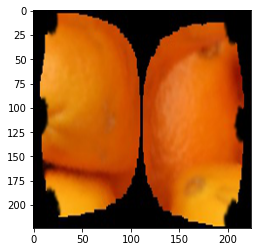

In [ ]:
index = 2
imges, label = train_dataset.__getitem__(index)

img_val = imges
img_val = img_val.numpy().transpose((1, 2, 0))
print("--------------------")
print(img_val.shape)
plt.imshow(img_val)
plt.show()


In [ ]:
#code adapted from https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion(cm, classes, name, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    #print(cm)
    filename= name + "_confusion.png"
    path = F"/content/drive/My Drive/Colab Notebooks/Graphs/"
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:0.0f}".format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(path+filename)


In [ ]:
def plot_graph(training_losses,val_losses,epochs,string,name):
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel(string)

    filename = name + "_" + string + "_.png" 
    path = F"/content/drive/My Drive/Colab Notebooks/Graphs/{filename}"
    plt.title(string + 'per epoch - ' + "Simple classifier")
    
    plt.plot(range(epochs),training_losses,label="Training " + string)
    plt.plot(range(epochs),val_losses,label="Validation " + string)
    plt.legend()
    plt.savefig(path+filename)
    print(path+filename)

In [ ]:
# This function will test mask image generation, not the difference between original and generated images
  
def test_model(model, criterion, name):

    model.eval()
    test_epoch_loss = 0
    test_correct = 0
    best_accuracy = 0
    class_correct = list(0 for i in range(N_CLASSES))
    class_total = list(0 for i in range(N_CLASSES))
    mean_accuracies = list(0 for i in range(n_iterations))
    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    labelslist=torch.zeros(0,dtype=torch.long, device='cpu')

    with torch.no_grad():
        accuracies = [[] for i in range(n_iterations)]
        #for index,(images, anno, labels) in enumerate(testloader):
        for index,(images, labels) in enumerate(testloader):
            images, labels = images.cuda(), labels.cuda()

            predicted = model(images)
            loss = criterion(predicted,labels)

            test_epoch_loss += loss.item()

            best_predicted = predicted
            _, predicted_l = torch.max(best_predicted.data, 1)
            test_correct += (predicted_l == labels).sum().item()
            c = (predicted_l == labels).squeeze()

            predlist=torch.cat([predlist,predicted_l.view(-1).cpu()])
            labelslist=torch.cat([labelslist,labels.view(-1).cpu()])

            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    test_epoch_loss /= len(testloader)
    print('\nTest loss: {:.4f} \nTesting Accuracy: {}/{} ({:.2f}%)'.format(
          test_epoch_loss, test_correct, len(testloader.dataset),
          100. * test_correct / len(testloader.dataset)))
    for i in range(N_CLASSES):
        print("{} Class Accuracy: {}/{} ({:.2f}%)".format(classes_list[i],class_correct[i],class_total[i],100*class_correct[i]/class_total[i]))

    precision = precision_score(predlist.numpy(), labelslist.numpy(), average='macro')
    recall = recall_score(predlist.numpy(), labelslist.numpy(), average='macro')
    accuracy = accuracy_score(predlist.numpy(), labelslist.numpy())
    f1 = fbeta_score(predlist.numpy(), labelslist.numpy(), 1, average='macro') #1 means f_1 measure
    print("Classifier has Acc=%0.3f P=%0.3f R=%0.3f F1=%0.3f" % (accuracy,precision,recall,f1))
    conf_matrix=confusion_matrix(labelslist.numpy(), predlist.numpy())
    plt.figure(figsize=(8, 8))
    plot_confusion(conf_matrix, classes_list, name, 'Confusion matrix')
    print(classification_report(labelslist.numpy(), predlist.numpy(),target_names=classes_list))

    return mean_accuracies

### CONST data

In [ ]:
# for FC layer's input size computation
img_shapes = [224, 224]

DEBUG = False
if DEBUG:
    NUM_EPOCS = 10
else:
    NUM_EPOCS = 30

n_iterations = 50
N_CLASSES = 20
FC_H = img_shapes[0]//2**4 # 4 is max plling layer num
FC_W = img_shapes[1]//2**4

### Network model

In [ ]:
# Load pre-trained VGG-16
use_pretrained = True
net = models.mobilenet_v2(pretrained=use_pretrained)

# Replacement last layer output for 20 classes
net.classifier[1] = nn.Linear(in_features=1280, out_features=N_CLASSES)

net.cuda()

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

### Loss function

In [ ]:
# Loss fuc setting
criterion = nn.CrossEntropyLoss()

### Optimization method

In [ ]:
# Optimization setting
optimizer = optim.SGD(net.parameters(), lr=0.008, momentum=0.9)

### Training & Test for model

In [ ]:
def train_model(model, dataloaders_dict, criterion, optimizer, num_epochs, name, folder_name, debug_mode=False):

    global best_accuracy;
    global training_losses; global val_losses;
    global train_accuracies; global val_accuracies;
    global epochs;
    global stats; 
    for epoch in range(epochs,num_epochs):
        epoch = epoch + 1
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')

        # loop for training and validation every epoch
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()   # training mode
            else:
                model.eval()    # validation mode

            epoch_loss = 0.0    # epoch loss
            epoch_corrects = 0  # epoch correct

            #for images, anno, labels in tqdm(dataloaders_dict[phase]):
            for images, labels in tqdm(dataloaders_dict[phase]):
                #images, anno, labels = images.cuda(), anno.cuda(), labels.cuda()
                images, labels = images.cuda(), labels.cuda()
      
                # initialize optimizer
                optimizer.zero_grad()

                # feedforward calc
                with torch.set_grad_enabled(phase == 'train'):
                    predicted = model(images)
                    loss = criterion(predicted, labels)       # loss calc
                    preds = predicted.max(1,keepdim=True)[1]  # label preds

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # calc of iter results
                    epoch_loss += loss.item()
                    epoch_corrects += preds.eq(labels.view_as(preds)).sum().item()

            print(epoch_corrects)
            epoch_loss = epoch_loss / len(index_dict[phase])
            epoch_acc = epoch_corrects / len(index_dict[phase]) *100.
            
            # stats data save
            if phase == 'train':
                training_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)

                # best model save
                if (epoch_acc > best_accuracy) and debug_mode==False:
                    best_accuracy = epoch_acc
                    best_model = deepcopy(model)
                    
                    path = F"/content/drive/My Drive/Colab Notebooks/PhD/{folder_name}/{name}.tar"
                    torch.save({"best_model":model.state_dict(),
                                "best_acc":best_accuracy
                                },path)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        if epoch%2==0:
            # Colab's disconnection timing while saving data might cause the broken save data against our hope.
            # So, results every epochs will be saved every epochs.
            
            total_name = name+"_epoch"+str(epoch)+".tar"

            path = F"/content/drive/My Drive/Colab Notebooks/PhD/{folder_name}/{total_name}"
            torch.save({
                "epoch":epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "train_loss":training_losses,
                "val_loss":val_losses,
                "train_acc":train_accuracies,
                "val_acc":val_accuracies
                }, path)
        print('-------------')

    print("Lowest training loss", min(training_losses))
    print("Lowest validation loss", min(val_losses))
    print("Highest training accuracy",max(train_accuracies))
    print("Highest validation accuracy",max(val_accuracies))
    print('-------------')

    stats.append(training_losses)
    stats.append(train_accuracies)
    stats.append(val_losses)
    stats.append(val_accuracies)

    return best_model, stats

In [ ]:
LOAD_STATE = False
EPOCH = 40             # This values need to check the latest tar ffile name with epoch.
name = "06_mobilenet"
folder_name = "mobilenet"

if LOAD_STATE:
    stats=[];
    PATH1 =  F"/content/drive/My Drive/Colab Notebooks/PhD/{folder_name}/{name}.tar"

    checkpoint = torch.load(PATH1)
    best_model = net
    best_model.load_state_dict( checkpoint["best_model"] )
    best_accuracy = 0#checkpoint["best_acc"]

    # Colab's disconnection timing while saving data might cause the broken save data against our hope.
    # So, results every epochs will be saved every epochs.
    total_name = name+"_epoch"+str(EPOCH)+".tar"
    PATH2 =  F"/content/drive/My Drive/Colab Notebooks/PhD/{folder_name}/{total_name}"

    checkpoint = torch.load(PATH2)
    epochs = checkpoint["epoch"]
    net.load_state_dict( checkpoint["model_state_dict"] )
    optimizer.load_state_dict( checkpoint["optimizer_state_dict"] )
    training_losses = checkpoint["train_loss"]; val_losses = checkpoint["val_loss"];
    train_accuracies = checkpoint["train_acc"]; val_accuracies = checkpoint["val_acc"];
    stats.append(training_losses)
    stats.append(train_accuracies)
    stats.append(val_losses)
    stats.append(val_accuracies)

else:
    # start point
    best_model=net;
    best_accuracy = 0;
    training_losses = []; val_losses = [];
    train_accuracies = []; val_accuracies = [];
    stats=[];
    epochs=0;


In [ ]:
best_model, stats = train_model(net, dataloaders_dict, criterion, optimizer, NUM_EPOCS, name, folder_name, DEBUG)

Epoch 1/30
-------------



180083
train Loss: 0.0359 Acc: 63.6030



51158
val Loss: 0.0268 Acc: 72.2734
-------------
Epoch 2/30
-------------



208715
train Loss: 0.0256 Acc: 73.7155



54632
val Loss: 0.0221 Acc: 77.1813
-------------
Epoch 3/30
-------------



220226
train Loss: 0.0215 Acc: 77.7810



56615
val Loss: 0.0194 Acc: 79.9828
-------------
Epoch 4/30
-------------



228850
train Loss: 0.0184 Acc: 80.8269



57672
val Loss: 0.0179 Acc: 81.4760
-------------
Epoch 5/30
-------------



235228
train Loss: 0.0162 Acc: 83.0795



58574
val Loss: 0.0165 Acc: 82.7503
-------------
Epoch 6/30
-------------



240556
train Loss: 0.0143 Acc: 84.9613



60453
val Loss: 0.0141 Acc: 85.4049
-------------
Epoch 7/30
-------------



245168
train Loss: 0.0127 Acc: 86.5902



60755
val Loss: 0.0137 Acc: 85.8315
-------------
Epoch 8/30
-------------



249296
train Loss: 0.0112 Acc: 88.0481



61549
val Loss: 0.0125 Acc: 86.9533
-------------
Epoch 9/30
-------------



252908
train Loss: 0.0100 Acc: 89.3239



62200
val Loss: 0.0116 Acc: 87.8730
-------------
Epoch 10/30
-------------



256113
train Loss: 0.0089 Acc: 90.4558



62840
val Loss: 0.0108 Acc: 88.7771
-------------
Epoch 11/30
-------------



258860
train Loss: 0.0080 Acc: 91.4260



63129
val Loss: 0.0105 Acc: 89.1854
-------------
Epoch 12/30
-------------



261393
train Loss: 0.0071 Acc: 92.3207



63259
val Loss: 0.0104 Acc: 89.3691
-------------
Epoch 13/30
-------------



263204
train Loss: 0.0065 Acc: 92.9603



63318
val Loss: 0.0104 Acc: 89.4524
-------------
Epoch 14/30
-------------



265123
train Loss: 0.0059 Acc: 93.6380



64128
val Loss: 0.0094 Acc: 90.5967
-------------
Epoch 15/30
-------------



267009
train Loss: 0.0053 Acc: 94.3042



64347
val Loss: 0.0092 Acc: 90.9061
-------------
Epoch 16/30
-------------



268230
train Loss: 0.0049 Acc: 94.7354



64720
val Loss: 0.0086 Acc: 91.4331
-------------
Epoch 17/30
-------------



269375
train Loss: 0.0045 Acc: 95.1398



65209
val Loss: 0.0081 Acc: 92.1239
-------------
Epoch 18/30
-------------



270575
train Loss: 0.0041 Acc: 95.5636



64978
val Loss: 0.0085 Acc: 91.7976
-------------
Epoch 19/30
-------------



271329
train Loss: 0.0038 Acc: 95.8299



65379
val Loss: 0.0078 Acc: 92.3641
-------------
Epoch 20/30
-------------



272177
train Loss: 0.0035 Acc: 96.1294



65339
val Loss: 0.0081 Acc: 92.3076
-------------
Epoch 21/30
-------------



273086
train Loss: 0.0032 Acc: 96.4505



65424
val Loss: 0.0079 Acc: 92.4277
-------------
Epoch 22/30
-------------



273847
train Loss: 0.0030 Acc: 96.7192



65245
val Loss: 0.0085 Acc: 92.1748
-------------
Epoch 23/30
-------------



274550
train Loss: 0.0028 Acc: 96.9675



65941
val Loss: 0.0072 Acc: 93.1581
-------------
Epoch 24/30
-------------



275162
train Loss: 0.0026 Acc: 97.1837



65799
val Loss: 0.0077 Acc: 92.9574
-------------
Epoch 25/30
-------------



275610
train Loss: 0.0024 Acc: 97.3419



66102
val Loss: 0.0072 Acc: 93.3855
-------------
Epoch 26/30
-------------



276091
train Loss: 0.0023 Acc: 97.5118



65820
val Loss: 0.0076 Acc: 92.9871
-------------
Epoch 27/30
-------------



276473
train Loss: 0.0022 Acc: 97.6467



66345
val Loss: 0.0070 Acc: 93.7288
-------------
Epoch 28/30
-------------



276894
train Loss: 0.0020 Acc: 97.7954



66325
val Loss: 0.0069 Acc: 93.7006
-------------
Epoch 29/30
-------------



277302
train Loss: 0.0019 Acc: 97.9395



66619
val Loss: 0.0067 Acc: 94.1159
-------------
Epoch 30/30
-------------



277671
train Loss: 0.0018 Acc: 98.0698



66678
val Loss: 0.0066 Acc: 94.1993
-------------
Lowest training loss 0.0017517410681241522
Lowest validation loss 0.006568036845532462
Highest training accuracy 98.06983216546112
Highest validation accuracy 94.1992540687161
-------------


/content/drive/My Drive/Colab Notebooks/Graphs/06_mobilenet_Loss _.png06_mobilenet_Loss _.png
/content/drive/My Drive/Colab Notebooks/Graphs/06_mobilenet_Accuracy _.png06_mobilenet_Accuracy _.png


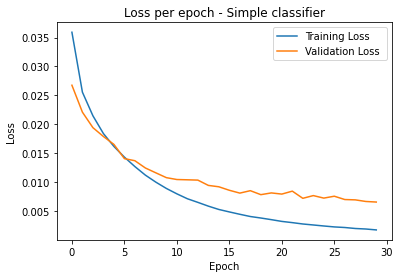

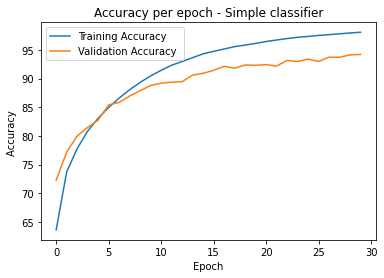

In [ ]:
plt.rcParams["figure.figsize"] = (6,4)
plot_graph(stats[0],stats[2],NUM_EPOCS,"Loss ",name)
plot_graph(stats[1],stats[3],NUM_EPOCS,"Accuracy ",name)


Test loss: 0.4385 
Testing Accuracy: 1814/2000 (90.70%)
apple Class Accuracy: 88/100 (88.00%)
banana Class Accuracy: 89/100 (89.00%)
bear Class Accuracy: 89/100 (89.00%)
bell_pepper Class Accuracy: 92/100 (92.00%)
bird Class Accuracy: 92/100 (92.00%)
broccoli Class Accuracy: 92/100 (92.00%)
cat Class Accuracy: 92/100 (92.00%)
cauliflower Class Accuracy: 92/100 (92.00%)
cow Class Accuracy: 91/100 (91.00%)
dog Class Accuracy: 85/100 (85.00%)
elephant Class Accuracy: 91/100 (91.00%)
fox Class Accuracy: 90/100 (90.00%)
goat Class Accuracy: 81/100 (81.00%)
horse Class Accuracy: 88/100 (88.00%)
mashed_potato Class Accuracy: 95/100 (95.00%)
orange Class Accuracy: 87/100 (87.00%)
pineapple Class Accuracy: 92/100 (92.00%)
pomegranate Class Accuracy: 96/100 (96.00%)
tomato Class Accuracy: 96/100 (96.00%)
zebra Class Accuracy: 96/100 (96.00%)
Classifier has Acc=0.907 P=0.907 R=0.908 F1=0.907
               precision    recall  f1-score   support

        apple       0.91      0.88      0.89     

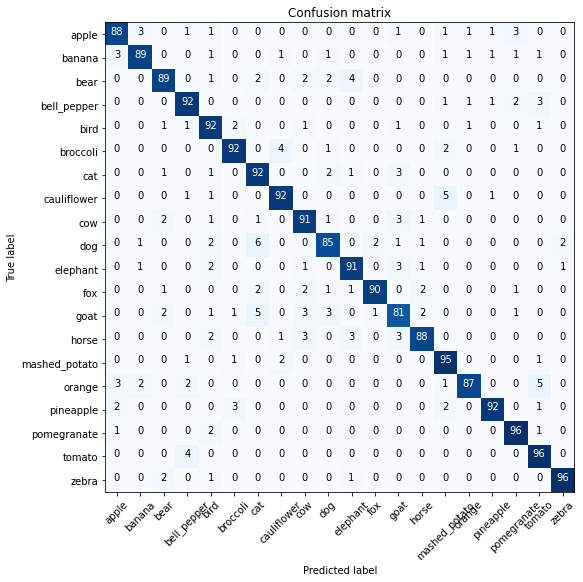

In [ ]:
result = test_model(best_model, criterion, name)

##backup

In [ ]:
best_model, stats = train_model(net, dataloaders_dict, criterion, optimizer, NUM_EPOCS, name, folder_name, DEBUG)

Epoch 1/30
-------------



180142
train Loss: 0.0359 Acc: 63.6238



50528
val Loss: 0.0278 Acc: 71.3834
-------------
Epoch 2/30
-------------



204612
train Loss: 0.0270 Acc: 72.2663



53413
val Loss: 0.0236 Acc: 75.4591
-------------
Epoch 3/30
-------------



218210
train Loss: 0.0222 Acc: 77.0690



54632
val Loss: 0.0222 Acc: 77.1813
-------------
Epoch 4/30
-------------



226731
train Loss: 0.0191 Acc: 80.0785



57230
val Loss: 0.0184 Acc: 80.8516
-------------
Epoch 5/30
-------------



233577
train Loss: 0.0168 Acc: 82.4964



58500
val Loss: 0.0168 Acc: 82.6458
-------------
Epoch 6/30
-------------



239193
train Loss: 0.0147 Acc: 84.4799



59999
val Loss: 0.0146 Acc: 84.7635
-------------
Epoch 7/30
-------------



244035
train Loss: 0.0130 Acc: 86.1900



60334
val Loss: 0.0141 Acc: 85.2368
-------------
Epoch 8/30
-------------



248096
train Loss: 0.0117 Acc: 87.6243



61679
val Loss: 0.0124 Acc: 87.1369
-------------
Epoch 9/30
-------------



251599
train Loss: 0.0105 Acc: 88.8615



61786
val Loss: 0.0124 Acc: 87.2881
-------------
Epoch 10/30
-------------



254924
train Loss: 0.0093 Acc: 90.0359



62156
val Loss: 0.0119 Acc: 87.8108
-------------
Epoch 11/30
-------------



257485
train Loss: 0.0084 Acc: 90.9404



63225
val Loss: 0.0104 Acc: 89.3210
-------------
Epoch 12/30
-------------



259617
train Loss: 0.0077 Acc: 91.6934



62650
val Loss: 0.0112 Acc: 88.5087
-------------
Epoch 13/30
-------------



262090
train Loss: 0.0069 Acc: 92.5668



63508
val Loss: 0.0103 Acc: 89.7208
-------------
Epoch 14/30
-------------



263865
train Loss: 0.0063 Acc: 93.1937



64540
val Loss: 0.0090 Acc: 91.1788
-------------
Epoch 15/30
-------------



265683
train Loss: 0.0057 Acc: 93.8358



64550
val Loss: 0.0088 Acc: 91.1929
-------------
Epoch 16/30
-------------



267271
train Loss: 0.0052 Acc: 94.3967



64907
val Loss: 0.0086 Acc: 91.6973
-------------
Epoch 17/30
-------------



268364
train Loss: 0.0048 Acc: 94.7827



64908
val Loss: 0.0086 Acc: 91.6987
-------------
Epoch 18/30
-------------



269617
train Loss: 0.0044 Acc: 95.2253



64986
val Loss: 0.0085 Acc: 91.8089
-------------
Epoch 19/30
-------------



270867
train Loss: 0.0040 Acc: 95.6667



65376
val Loss: 0.0079 Acc: 92.3599
-------------
Epoch 20/30
-------------



271665
train Loss: 0.0037 Acc: 95.9486



65552
val Loss: 0.0076 Acc: 92.6085
-------------
Epoch 21/30
-------------



272413
train Loss: 0.0035 Acc: 96.2128



65652
val Loss: 0.0076 Acc: 92.7498
-------------
Epoch 22/30
-------------



273039
train Loss: 0.0033 Acc: 96.4339



65640
val Loss: 0.0080 Acc: 92.7328
-------------
Epoch 23/30
-------------



273977
train Loss: 0.0030 Acc: 96.7652



65741
val Loss: 0.0075 Acc: 92.8755
-------------
Epoch 24/30
-------------



274367
train Loss: 0.0029 Acc: 96.9029



65765
val Loss: 0.0075 Acc: 92.9094
-------------
Epoch 25/30
-------------



274810
train Loss: 0.0027 Acc: 97.0594



65979
val Loss: 0.0075 Acc: 93.2117
-------------
Epoch 26/30
-------------



275495
train Loss: 0.0025 Acc: 97.3013



66212
val Loss: 0.0072 Acc: 93.5409
-------------
Epoch 27/30
-------------



275747
train Loss: 0.0024 Acc: 97.3903



65820
val Loss: 0.0079 Acc: 92.9871
-------------
Epoch 28/30
-------------



276358
train Loss: 0.0022 Acc: 97.6061



66258
val Loss: 0.0070 Acc: 93.6059
-------------
Epoch 29/30
-------------



276763
train Loss: 0.0021 Acc: 97.7491



66206
val Loss: 0.0074 Acc: 93.5324
-------------
Epoch 30/30
-------------



275949
train Loss: 0.0024 Acc: 97.4616



66342
val Loss: 0.0070 Acc: 93.7246
-------------
Lowest training loss 0.0020695249479603926
Lowest validation loss 0.0069959625699342635
Highest training accuracy 97.74913822332731
Highest validation accuracy 93.7245705244123
-------------


/content/drive/My Drive/Colab Notebooks/Graphs/06_mobilenet_Loss _.png06_mobilenet_Loss _.png
/content/drive/My Drive/Colab Notebooks/Graphs/06_mobilenet_Accuracy _.png06_mobilenet_Accuracy _.png


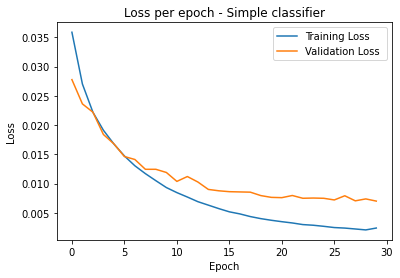

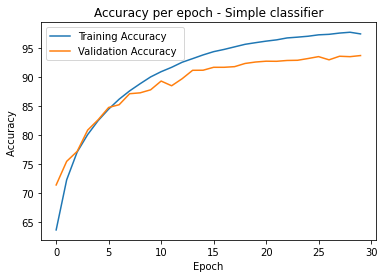

In [ ]:
plt.rcParams["figure.figsize"] = (6,4)
plot_graph(stats[0],stats[2],NUM_EPOCS,"Loss ",name)
plot_graph(stats[1],stats[3],NUM_EPOCS,"Accuracy ",name)


Test loss: 0.3431 
Testing Accuracy: 1842/2000 (92.10%)
apple Class Accuracy: 86/100 (86.00%)
banana Class Accuracy: 94/100 (94.00%)
bear Class Accuracy: 92/100 (92.00%)
bell_pepper Class Accuracy: 94/100 (94.00%)
bird Class Accuracy: 87/100 (87.00%)
broccoli Class Accuracy: 94/100 (94.00%)
cat Class Accuracy: 89/100 (89.00%)
cauliflower Class Accuracy: 92/100 (92.00%)
cow Class Accuracy: 80/100 (80.00%)
dog Class Accuracy: 89/100 (89.00%)
elephant Class Accuracy: 94/100 (94.00%)
fox Class Accuracy: 95/100 (95.00%)
goat Class Accuracy: 83/100 (83.00%)
horse Class Accuracy: 95/100 (95.00%)
mashed_potato Class Accuracy: 97/100 (97.00%)
orange Class Accuracy: 93/100 (93.00%)
pineapple Class Accuracy: 97/100 (97.00%)
pomegranate Class Accuracy: 97/100 (97.00%)
tomato Class Accuracy: 96/100 (96.00%)
zebra Class Accuracy: 98/100 (98.00%)
Classifier has Acc=0.921 P=0.921 R=0.922 F1=0.921
               precision    recall  f1-score   support

        apple       0.92      0.86      0.89     

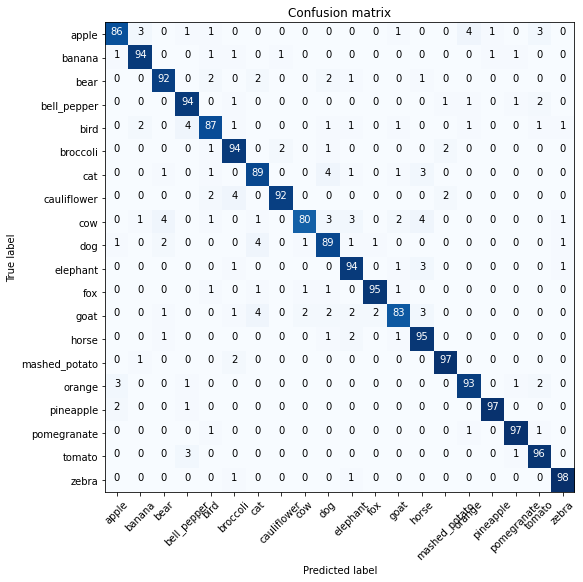

In [ ]:
result = test_model(best_model, criterion, name)